# Lyrics sentiment analysis

In [ ]:
!pip install spacy pandas seaborn transformers torch pysentimiento

     |████████████████████████████████| 2.8 MB 5.2 MB/s 
     |████████████████████████████████| 636 kB 48.4 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 895 kB 34.3 MB/s 
     |████████████████████████████████| 3.3 MB 37.4 MB/s 
     |████████████████████████████████| 184 kB 48.5 MB/s 
     |████████████████████████████████| 264 kB 49.7 MB/s 
     |████████████████████████████████| 119 kB 43.4 MB/s 
     |████████████████████████████████| 243 kB 42.9 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=cc0590dba2a3df4098e0319042ebe9f251fd72f6cccee5c254e11c0f400dd219
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import spacy
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(palette="Blues_r", style="white")

## Loading the data

We are gonna use the [musiXmatch Dataset](http://millionsongdataset.com/musixmatch/), which consists of 779k lyrics in a bag-of-word format. Additional information can be gathered by looking up the ID in the [Million Song Dataset](http://millionsongdataset.com/).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/mxm

/content/gdrive/MyDrive/mxm


Load train test lyrics data

In [ ]:
# Line looks like this track_id, mxm track id, w_id1:wc1, w_id2: wc2, ...
# TRAAAAV128F421A322,4623710,1:6,2:4,...

train_file_path = "mxm_dataset_train.txt"
test_file_path = "mxm_dataset_test.txt"

def word_counts_to_dict(words):
  res = {}
  for word_with_count in words:
    word, count = word_with_count.split(":")
    res[word] = int(count)
  return res

def load_lyrics_word_bag(file_path):
  with open(file_path) as file:
    res = []
    for line in file.readlines():
      # skip comment or top words line
      if line.startswith("#") or line.startswith("%"):
        continue
      track_id_msd, track_id_mxm, *words = line.split(",")
      res.append({"track_id_msd": track_id_msd.strip(), "track_id_mxm": track_id_mxm.strip(), "word_counts": word_counts_to_dict(words)})
    return res

train = load_lyrics_word_bag(train_file_path)
test = load_lyrics_word_bag(test_file_path)

load vocab

In [ ]:
vocab = []
with open(train_file_path) as file:
    for line in file.readlines():
      if line.startswith("%"):
        vocab = line[1:].split(",")
        break


In [ ]:
vocab[:5]

['i', 'the', 'you', 'to', 'and']

Load additional information

In [ ]:
# Million Song Dataset
msd_df = None

msd_file_path = "mxm_779k_matches.txt"


# Format
#     #    -> comment, ignore
#     tid|artist name|title|mxm tid|artist_name|title
#        tid          -> Million Song Dataset track ID
#        artist name  -> artist name in the MSD
#        title        -> title in the MSD
#        mxm tid      -> musiXmatch track ID
#        artist name  -> artist name for mXm
#        title        -> title for mXm
#        |            -> actual separator: <SEP>
# TRMMMKD128F425225D<SEP>Karkkiautomaatti<SEP>Tanssi vaan<SEP>4418550<SEP>Karkkiautomaatti<SEP>Tanssi vaan

with open(msd_file_path) as file:
  res = []
  for line in file.readlines():
    # skip comments
    if line.startswith("#"):
      continue
    track_id_msd, artist_name_msd, title_msd, track_id_mxm, artist_name_mxm, title_mxm = line.split("<SEP>")
    res.append({"track_id_msd": track_id_msd.strip(), "artist_name_msd": artist_name_msd.strip(), "title_msd": title_msd.strip(), 
                "track_id_mxm": track_id_mxm.strip(), "artist_name_mxm": artist_name_mxm.strip(),})
  msd_df = pd.DataFrame(res)


Add genre information

In [ ]:
genre_df = None

# FORMAT: # - denotes a comment
#          % - one line after comments, column names
#            - rest is data, comma-separated, one line per song
# %genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
# classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames 


genre_file_path = "msd_genre_dataset.txt"

with open(genre_file_path) as file:
  res = []
  for line in file.readlines():
    # skip comments and description
    # Since line 10 starts with - but is still description, we also need to skip it
    if line.startswith("#") or line.strip().startswith("%") or line.strip().startswith("-"):
      continue
    genre, track_id_msd, *_ = line.split(",")
    res.append({"track_id_msd": track_id_msd.strip(), "genre": genre})
  genre_df = pd.DataFrame(res)

Merge them

In [ ]:
# Add validation so each song gets a genre assigned
msd_genre_df = pd.merge(msd_df, genre_df, validate="one_to_many")

In [ ]:
msd_genre_df.head()

,track_id_msd,artist_name_msd,title_msd,track_id_mxm,artist_name_mxm,genre
0,TRMMMUT128F42646E8,Shawn Colvin,(Looking For) The Heart Of Saturday,674743,Shawn Colvin,folk
1,TRMMMGL128F92FD6AB,Clifford T. Ward,Mad About You,6821012,Clifford T. Ward,classic pop and rock
2,TRMMWNY12903CF28D2,Warren Zevon,The Rest of the Night,1576953,Warren Zevon,classic pop and rock
3,TRMMWQU12903CF447F,Diablo Swing Orchestra,Lucy Fears the Morning Star,8859768,Diablo Swing Orchestra,metal
4,TRMMWHJ128F42869B2,The Surfaris,Wipeout,13843656,The Surfaris,classic pop and rock


Check for missing values

In [ ]:
msd_genre_df.isna().sum()

track_id_msd       0
artist_name_msd    0
title_msd          0
track_id_mxm       0
artist_name_mxm    0
genre              0
dtype: int64

Take a look at genre distribution

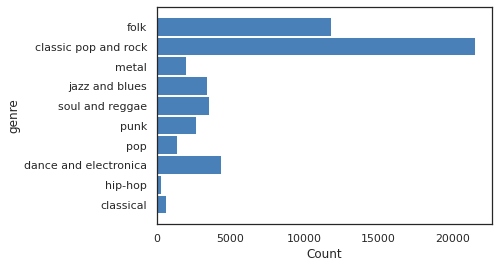

In [ ]:
sns.histplot(y=msd_genre_df["genre"])

add lyrics to df

In [ ]:
train_test_df = pd.concat([pd.DataFrame(train), pd.DataFrame(test)], axis=0)
full_df = pd.merge(msd_genre_df, train_test_df)

transform word_counts to lyrics

In [ ]:
def word_counts_to_lyrics(row):
  lyrics = []
  for ind, (word_id, count) in enumerate(row["word_counts"].items()):
    for i in range(count):
        lyrics.append(vocab[int(word_id)-1])


  return " ".join(lyrics)

full_df["lyrics"] = full_df.apply(word_counts_to_lyrics, axis=1)

In [ ]:
full_df.head()

,track_id_msd,artist_name_msd,title_msd,track_id_mxm,artist_name_mxm,genre,word_counts,lyrics
0,TRMMMUT128F42646E8,Shawn Colvin,(Looking For) The Heart Of Saturday,674743,Shawn Colvin,folk,"{'2': 36, '3': 25, '4': 2, '5': 8, '6': 2, '7'...",the the the the the the the the the the the th...
1,TRMMMGL128F92FD6AB,Clifford T. Ward,Mad About You,6821012,Clifford T. Ward,classic pop and rock,"{'1': 6, '2': 8, '3': 13, '4': 2, '5': 1, '6':...",i i i i i i the the the the the the the the yo...
2,TRMMWNY12903CF28D2,Warren Zevon,The Rest of the Night,1576953,Warren Zevon,classic pop and rock,"{'1': 1, '2': 31, '3': 2, '4': 1, '5': 2, '6':...",i the the the the the the the the the the the ...
3,TRMMWQU12903CF447F,Diablo Swing Orchestra,Lucy Fears the Morning Star,8859768,Diablo Swing Orchestra,metal,"{'2': 14, '3': 8, '4': 4, '5': 7, '6': 9, '7':...",the the the the the the the the the the the th...
4,TRMMHIG128F4228C77,Visaci Zamek,Traktor,6505358,Visací zámek,punk,"{'1': 1, '4': 2, '6': 3, '16': 2, '114': 1, '1...",i to to a a a do do tu se se se se si si je je...


Calculate doc score for each lyric and cluster them; Let's see if genres are clustered together in general

In [ ]:
from pysentimiento import EmotionAnalyzer

emotion_analyzer = EmotionAnalyzer(lang="en")


Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/999 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/540M [00:00<?, ?B/s]

In [ ]:
results = emotion_analyzer.predict(full_df["lyrics"])

  0%|          | 0/547 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 17495
  Batch size = 32


17495


In [ ]:
with open("./lyrics_emotions.txt", "w") as f:
  out = "\n".join([str(res) for res in results])
  #f.write(out)
  f.close()

NameError: ignored